<<<<<<< REMOTE CELL DELETED >>>>>>>
## 1. Introduction
Our dataset is a list of housing listings from the top 45 most populous cities in canada. We felt that it would be interesting and relevant (since we are first years looking for housing) to study this data and identify patterns in it. Our goal is to create a regression model that can predict price using number of beds, number of baths, and median income as predictors.

## 2. Tidying and Wrangling

In [40]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)
library(ggrepel)

ERROR: Error in library(ggrepel): there is no package called ‘ggrepel’


While combing through the data we noticed that some cities and provinces had been mislabeled. These were "Saskatoon, Ontario", "Winnipeg, Ontario", "Nanaimo, Ontario", and "Regina, Ontario". We should delete all these problematic rows from the dataset too

In [27]:
housing_clean <- housing_filter |> filter(!(city %in% c("Saskatoon", "Winnipeg", "Nanaimo", "Regina") & province == "Ontario"))

## 3. Preliminary Data Analysis

We felt that the best way to summarize the data would be the find mean house price for each city, and plot that against median income 

`summarise()` has grouped output by 'city', 'province'. You can override using
the `.groups` argument.


city,province,median_family_income,avg_price,average_beds,average_baths
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
White Rock,British Columbia,73000,2196517,3.727564,3.364316
Vancouver,British Columbia,90000,1829448,2.771896,2.459095
Maple Ridge,British Columbia,105000,1502772,3.599807,2.965284
⋮,⋮,⋮,⋮,⋮,⋮
Sault Ste. Marie,Ontario,73000,414296.9,3.203008,2.052632
Saint John,New Brunswick,74000,360716.2,3.525000,2.243750
Regina,Saskatchewan,90000,336246.1,3.153194,2.291395


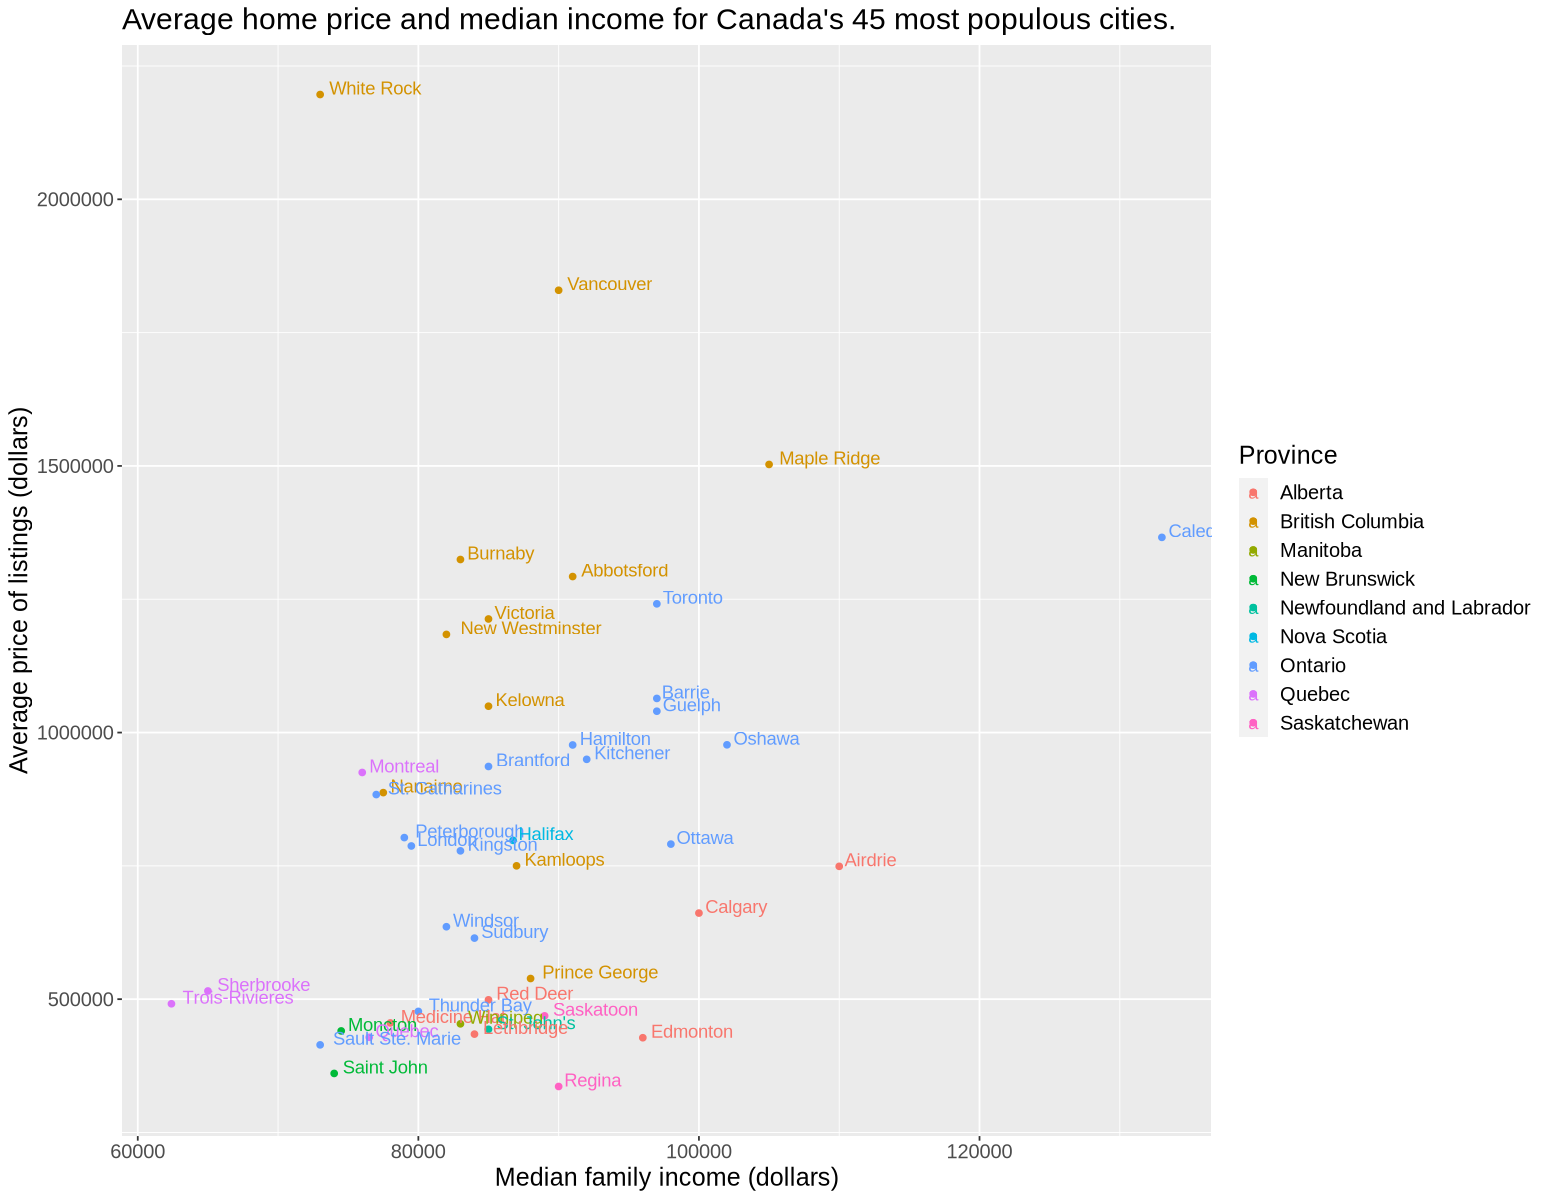

In [110]:
options(repr.plot.height = 10, repr.plot.width = 13)
housing_split <- initial_split(housing_clean, prop =0.8, strata = price)
housing_train <- training(housing_split)
housing_test <- testing(housing_split)



table_avg_price <- housing_train |>
group_by(city, province, median_family_income) |>
summarize(avg_price = mean(price), average_beds = mean(number_beds), average_baths = mean(number_baths)) |>
arrange(-avg_price)
table_avg_price


avg_price_plot <- ggplot(table_avg_price, aes(x = median_family_income, y = avg_price, color = province, label = city)) + geom_point() +
                labs(x = "Median family income (dollars)", y = "Average price of listings (dollars)", color = "Province",
                    title = "Average home price and median income for Canada's 45 most populous cities.") + geom_text(hjust = -0.1, vjust = 0) +
                theme(text = element_text(size = 15))
avg_price_plot

Although the graph looks a little messy, we've opted to leave labels on because it givees us a lot of information that we would otherwise have to comb through the table for. For example, White Rock, British Columbia could be considered the "least affordable" (for the average person) city, while Airdrie, Alberta would be the "most affordable" (for the average person). There is also a definite positive relationship between median family income, and average price.

We wanted to look at the nature of housing supply for each city, so we also measured the average number of beds, also the number of beds in  

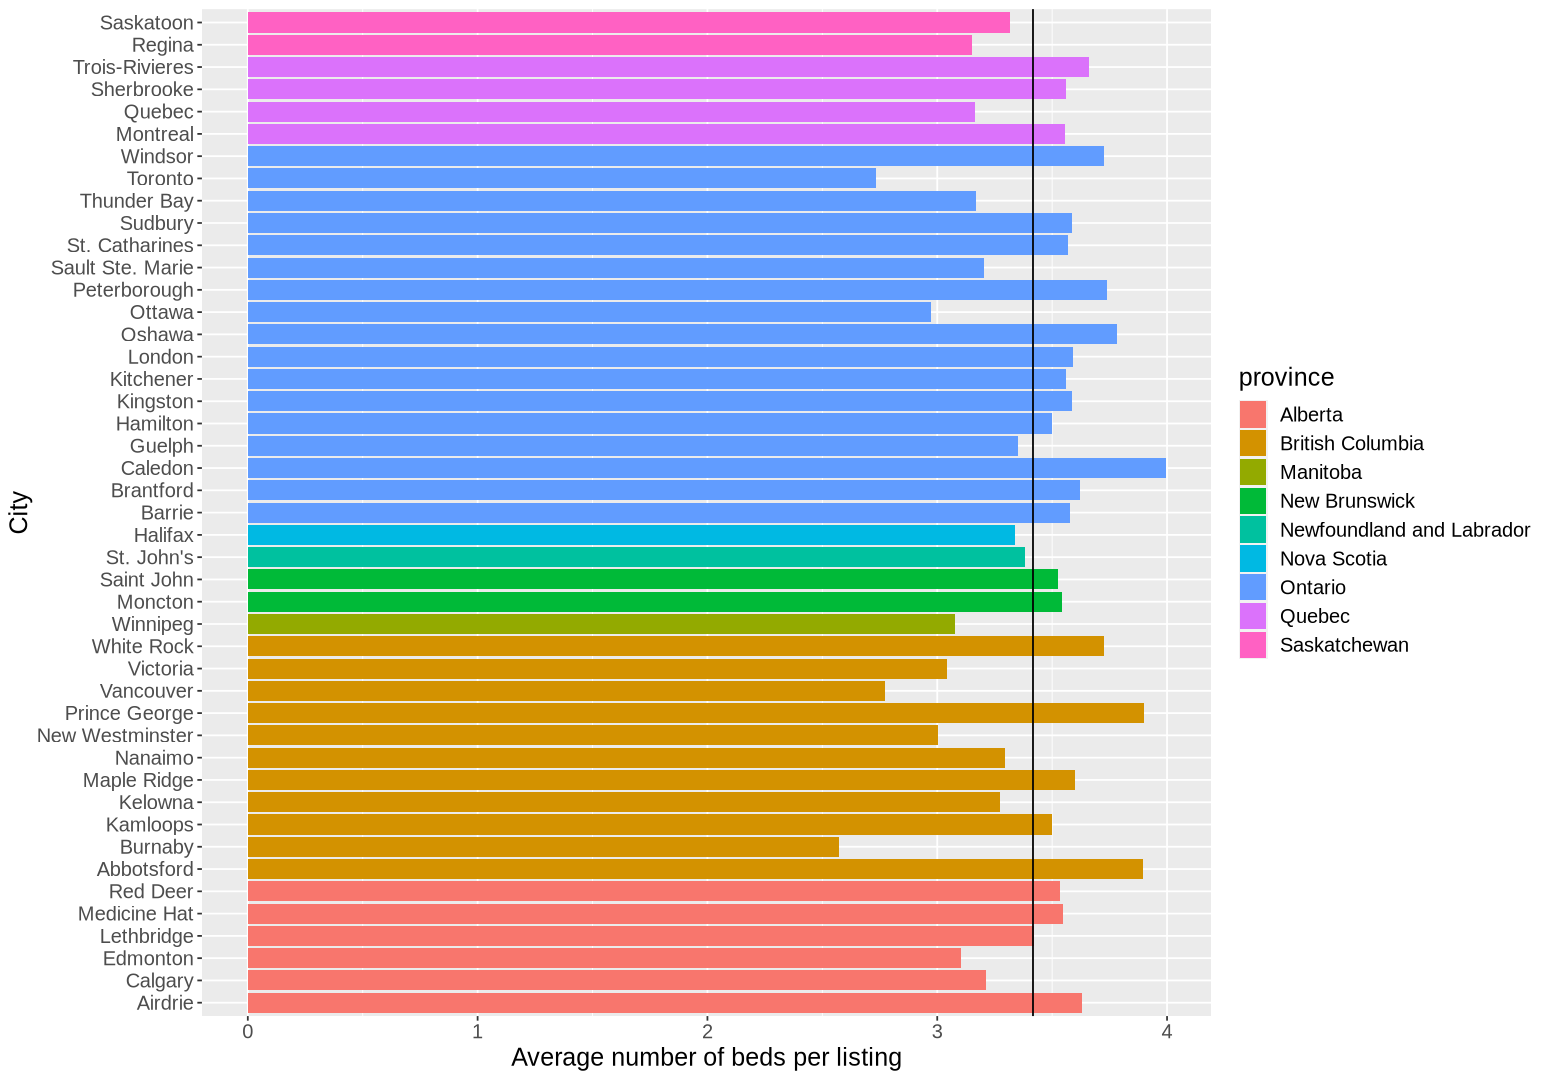

In [112]:
options(repr.plot.height = 9, repr.plot.width = 13)
average_bed_plot <- ggplot(table_avg_price, aes(y = fct_reorder(city, province), x = average_beds, fill = province)) +
                    geom_bar(stat = "identity") +
                    labs(x = "Average number of beds per listing", y = "City", color = "Province")+
                    geom_vline(xintercept = 3.416648)+
                    theme(text = element_text(size = 15))
average_bed_plot

We can now get ideas about which cities are more dense, and which ones are more suburban and have larger houses

`summarise()` has grouped output by 'city', 'Number_Beds_changed'. You can
override using the `.groups` argument.


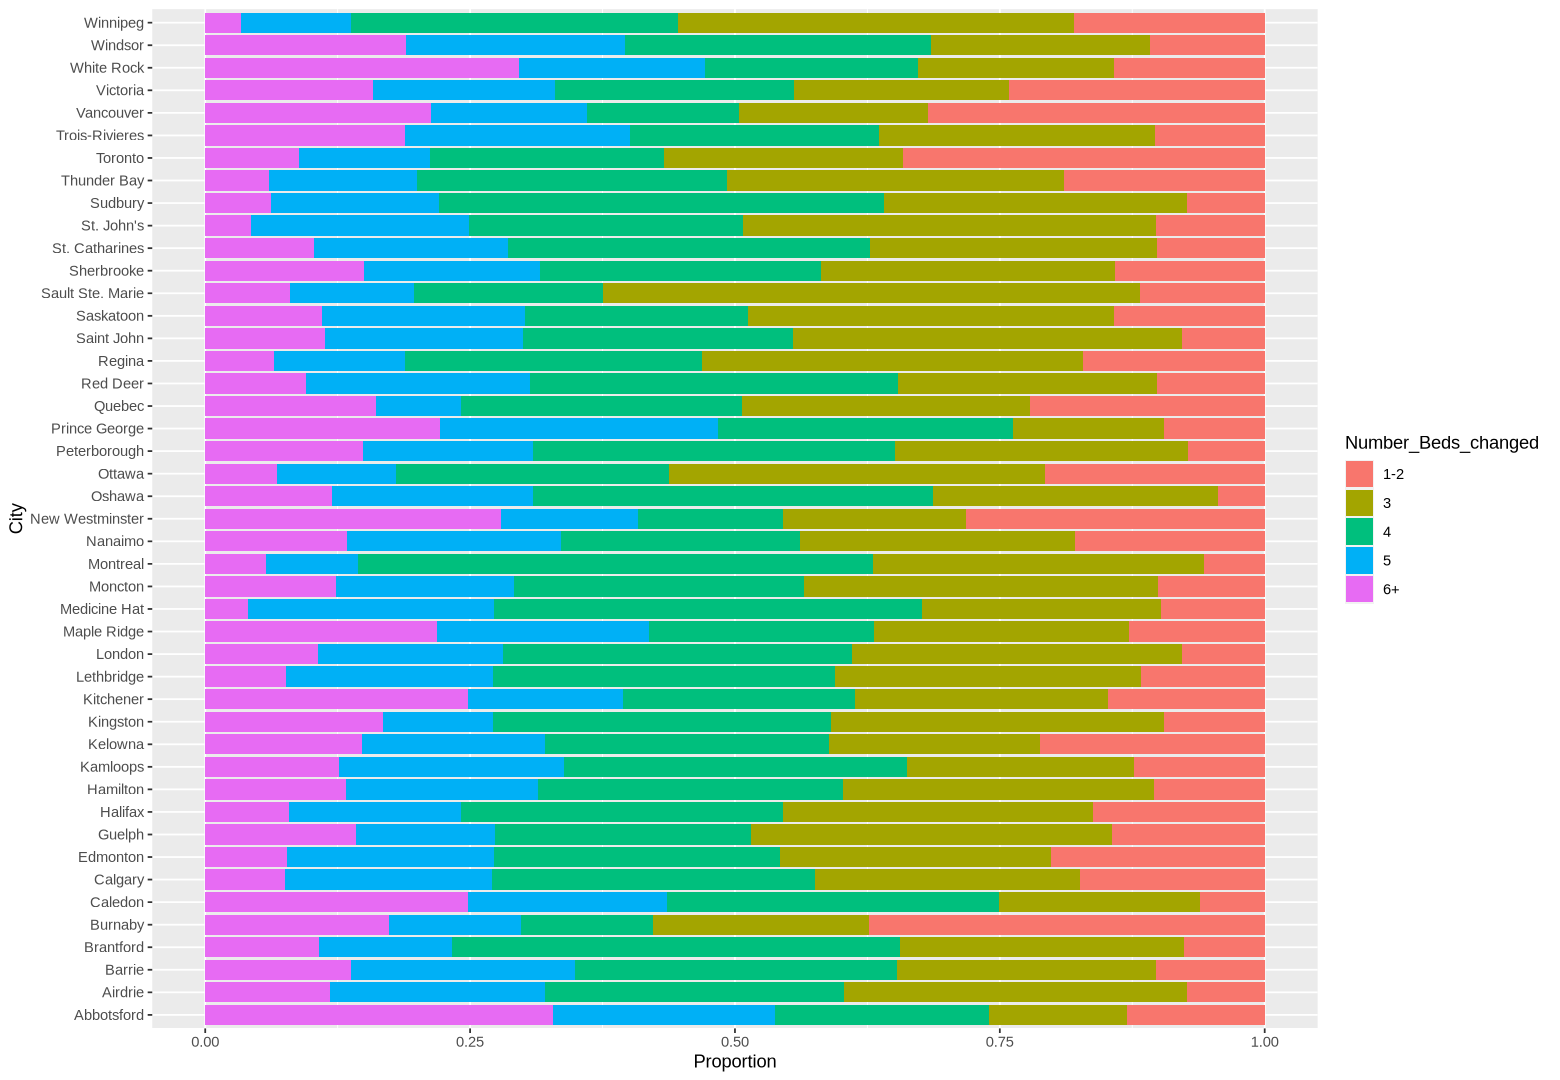

In [131]:
city <- housing_train |>
  mutate(Number_Beds_changed = case_when(
    number_beds <= 2 ~ "1-2" , 
    number_beds < 6 ~ as.character(number_beds),
    number_beds >= 6 ~ "6+")) |>
    mutate(Number_Beds_changed = as_factor(Number_Beds_changed))|> 
    group_by(city, Number_Beds_changed, number_beds)|>
    summarize(number_beds = sum(number_beds))

comparison <- city|>
              ggplot(aes(y= city, x= number_beds, fill = Number_Beds_changed))+
              geom_bar(stat = "identity", position = "fill")+
              labs(y = "City", x = "Proportion", color = "Number of beds")

comparison 

To get a better idea of the ditribution we made this bar chart, it seeme

## 3. Methods

We don't expect to see any meaningful corellation between address, latitude, longitude, and population with price, so we will be taking those out. It's also important to realize that median family income data is a column adding numeric value to city

In [102]:
housing_train_real <- housing_train |> select(-address, -latitude, -longitude, -population)
housing_train_real

city,price,number_beds,number_baths,province,median_family_income
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Toronto,439000,2,1,Ontario,97000
Toronto,438000,2,1,Ontario,97000
Toronto,448800,3,2,Ontario,97000
⋮,⋮,⋮,⋮,⋮,⋮
Halifax,6995000,4,5,Nova Scotia,86753
Halifax,1799900,5,3,Nova Scotia,86753
Halifax,6990000,5,5,Nova Scotia,86753


In order to visualize our results, we can create multiple scatter plots with the testing data. They will be price against number of beds, number of baths, and median family income. We can also plot the curve that represents our regression against each of these predictors.